In [1]:
import os
import pyvips
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

os.environ['VIPS_DISC_THRESHOLD'] = '10gb'

# Params
seed = 42
max_tile_num = 10000
drop_thr = 0.60
size = 1024
scale = 0.5

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
out_dir = os.path.join(results_dir, f'train_tiles_{size}_p{int(scale*100)}_drop{int(drop_thr*100)}_v6')
# v6: tma center crop, wsi normal tiling

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

def frame_image(img, frame_width: int):
    """ Add a frame of specified width (in pixels) to an image. """
    if img.ndim == 3:   # rgb or rgba array
        framed_img = np.zeros((img.shape[0]+frame_width*2, img.shape[1]+frame_width*2, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.zeros((img.shape[0]+frame_width*2, img.shape[1]+frame_width*2))
    framed_img[frame_width:-frame_width, frame_width:-frame_width] = img
    return framed_img

def pad_tile(tile, size: int):
    """ Pad tile to specified size (asymmetric padding, expecting tiles at the right or bottom edge of the image). """
    tile_ = tile
    tile_size = (size, size) if tile.ndim == 2 else (size, size, tile.shape[2])
    tile = np.zeros(tile_size, dtype=tile.dtype)
    tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
    return tile

def rescale_save_tile(tile, scale: float, p_img):
    """ Rescale tile and save it to disk. """
    new_size = int(tile.shape[0] * scale), int(tile.shape[1] * scale)
    Image.fromarray(tile).resize(new_size, Image.LANCZOS).save(p_img)
    return p_img

def extract_image_tiles(p_img, folder, size: int, scale: float, drop_thr: float, max_tile_num: int) -> (list, list, tuple):
    """ Extract tiles from image and save them to disk. """
    im = pyvips.Image.new_from_file(p_img)

    # TMA processing (center crop)
    if im.height < 5000 and im.width < 5000:
        size = size*2
        scale /= 2
        x = max((im.width - size) // 2, 0)
        y = max((im.height - size) // 2, 0)
        w = min(im.width, size)
        h = min(im.height, size)
        tile = im.crop(x, y, w, h).numpy()[..., :3]

        # Pad if necessary
        if tile.shape[:2] != (size, size):
            tile = pad_tile(tile, size)

        # Save tile
        p_img = os.path.join(folder, f"{0:06}_{int(x)}-{int(y)}.png")
        rescale_save_tile(tile, scale, p_img)

        # Add to tile list
        files = [p_img]
        valid_idxs = [(y, h, x, w)]

    # WSI processing (normal tiling)
    else:
        w = h = size
        idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]

        files = []
        valid_idxs = []
        tile_num = 0
        for k, (y, y_, x, x_) in enumerate(idxs):
            tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]

            # Pad if necessary
            if tile.shape[:2] != (size, size):
                tile = pad_tile(tile, size)
            
            # Drop background tiles
            mask_bg = np.sum(tile, axis=2) == 0
            if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
                continue
            
            # Save tile
            p_img = os.path.join(folder, f"{k:06}_{int(x)}-{int(y)}.png")
            rescale_save_tile(tile, scale, p_img)

            # Add to tile list
            files.append(p_img)
            valid_idxs.append((y, y_, x, x_))

            # Tile counter
            tile_num += 1
            if tile_num >= max_tile_num:
                break
    return files, valid_idxs, (im.width, im.height)

def extract_prune_tiles(idx_path_img, folder, size: int, scale: float, drop_thr: float, max_tile_num: int) -> None:
    """ Helper function for multiprocessing. """
    idx, p_img = idx_path_img
    print(f"processing #{idx}: {p_img}")
    folder = os.path.join(folder, os.path.splitext(os.path.basename(p_img))[0])
    os.makedirs(folder, exist_ok=True)
    extract_image_tiles(p_img, folder, size, scale, drop_thr, max_tile_num);

## Show the image tiles with segmentations for one test image

number of tiles: 1
tile size: (512, 512, 3)


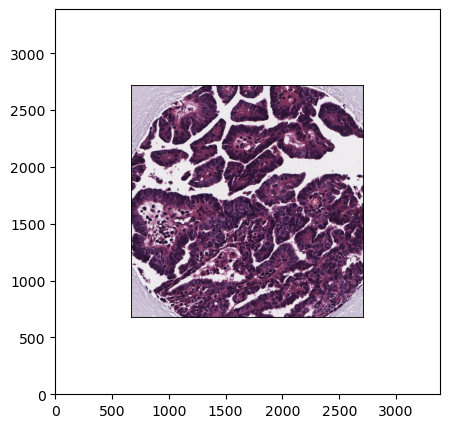

In [11]:
test_img_id = '4'
test_img_id = '91'
# test_img_id = '36302'
# test_img_id = '29084'

# test_img_id = '13987'
# test_img_id = '281'
# test_img_id = '48734'

os.makedirs('/tmp/ubc', exist_ok=True)
tiles_img, idx_list, (img_width, img_height) = extract_image_tiles(
    os.path.join(train_image_dir, f'{test_img_id}.png'), '/tmp/ubc', size=size, scale=scale, drop_thr=drop_thr, max_tile_num=max_tile_num)
print(f'number of tiles: {len(tiles_img)}')

if img_width < 5000 and img_height < 5000:
    plot_size = size*2
    fig = plt.figure(figsize=(5, 5))
else:
    plot_size = size
    fig = plt.figure(figsize=(16, 20))
ax = plt.gca()
for p_img, (y, y_, x, x_) in zip(tiles_img, idx_list):
    img = plt.imread(p_img)
    ax.imshow(frame_image(img, 2), extent=(x, x+plot_size, img_height-y-plot_size, img_height-y))
print(f"tile size: {img.shape}")

plt.xlim(0, img_width);
plt.ylim(0, img_height);

## Export all image tiles¶

In [ ]:
import glob
from tqdm.auto import tqdm
from joblib import Parallel, delayed

os.makedirs(out_dir, exist_ok=True)

ls = sorted(glob.glob(os.path.join(train_image_dir, '*.png')))
print(f"found images: {len(ls)}")
img_name = lambda p_img: os.path.splitext(os.path.basename(p_img))[0]
    
_= Parallel(n_jobs=8)(
    delayed(extract_prune_tiles)
    (id_pimg, out_dir, size=size, drop_thr=drop_thr, scale=scale, max_tile_num=max_tile_num)
    for id_pimg in tqdm(enumerate(ls), total=len(ls))
)

## Show some samples

In [ ]:
ls = [p for p in glob.glob(out_dir + '/*') if os.path.isdir(p)]
print(f"found folders: {len(ls)}")
ls = glob.glob(out_dir + '/*/*.png')
print(f"found images: {len(ls)}")

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
for i, p_img in enumerate(ls[:25]):
    img = plt.imread(p_img)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)